## Simulation setups
Covariates are sampled uniformly from $[-B,B]^p$, where $p$ is feature size.

Parameters
+ **K**: 2 (number of arms)
+ **p**: 3 (feature size, the last two coordinates are noise)
+ **assignment probability floor**: $t^{-\alpha}/K$ with $\alpha=0.5$.
+ **scores**: AIPW
+ **noise distribution**: $\mathcal{N}(0,1)$
+ **agent**: Thompson sampling
+ **T**: $20000$ (Sample size)
+ **batch-size**: $100$
+ **explore_T**: $50*K$, the first batch size to do pure exploration.

Compared weighting:
- $h_t=1$;
- $h_t=t^{-\alpha/2}$;
- $h_t=t^{-\alpha}$;
- $h_t=t^{-2\alpha}$;
- data-collection agent.


Evaluation metric: out-of-sample regret using $100,000$ separate samples drawn from $(X, Y(1), \dots, Y(K))$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os


In [2]:
from glob import glob
def read_files(file_name):
    files = glob(file_name)
    results = []
    for file in files:
        r = np.load(file)
        results.extend(r)
    return np.array(results)

In [3]:
results = read_files('results/synthetic_*.npy')

In [4]:
def get_df(results):
    l = len(results)
    df = []
    method = ['uniform',  r'$t^{-\alpha/2}$', r'$t^{-\alpha}$',  
              r'$t^{-2\alpha}$', 'TS agent']
    for i, m in zip(range(5,5+len(method)), method):
        df.append(pd.DataFrame({'T': np.array(results[:,0], dtype=int), 
                                'B': np.array(results[:,1], dtype=float),
                                'signal': np.array(results[:,2], dtype=float),
                                'floor_decay': np.array(results[:,3], dtype=float),
                                'policy_class': results[:, 4],
                               'regret': np.array(results[:,i], dtype=float),
                               'method': [m] * l}))
    return pd.concat(df)


In [5]:
df = get_df(results)
B = df['B'].unique()[0]

In [6]:
def plot_log_regret(ax):
    g = sns.lineplot(x='T', y='regret', hue='method', 
                     hue_order=['uniform', r'$t^{-\alpha/2}$',  r'$t^{-\alpha}$', 
                             r'$t^{-2\alpha}$', 
                             'TS agent',
                            ],
                     data=df,
                     ax=ax,
                    )

    ax.set_xlabel('Sample Size', fontsize=15)
    ax.set_ylabel('')
    ax.set_title('Log Regret', fontsize=15)
    ax.set_yscale('log')
    ax.legend([r'$h_t=1$', r'$h_t=t^{-\alpha/2}$', r'$h_t=t^{-\alpha}$',
        r'$h_t=t^{-2\alpha}$','TS agent'], ncol=1,fontsize=15)

In [8]:
def plot_outcome_model(ax):
    xs = np.linspace(-B, B, 1000)
    id_1 = xs < -1
    id_2 = (xs > -1) & (xs < 1)
    id_3 = xs > 1

    ax.plot(xs, xs ** 2 - 1, label=r'arm 1: $\mu_1(x)=x^2-1$')
    ax.plot(xs, 1 - xs ** 2, label=r'arm 2: $\mu_2(x)=1 -x^2$')
    ax.set_title('Outcome Model', fontsize=15)
    ax.set_xlabel(r'$X_0$', fontsize=15)
    ax.legend(fontsize=15)

## Figure 2

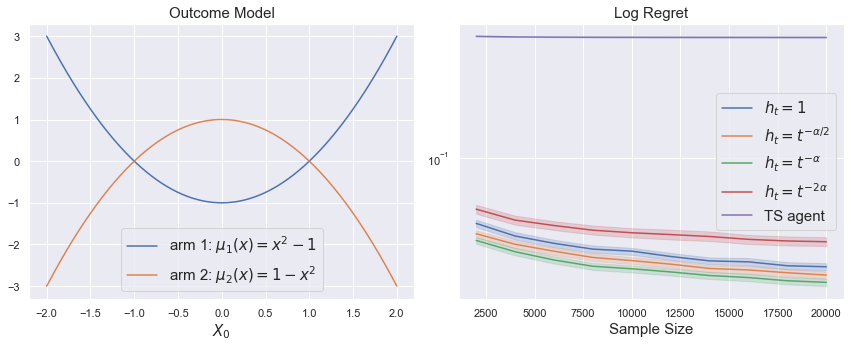

In [9]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_outcome_model(ax[0])
plot_log_regret(ax[1])
plt.tight_layout()
plt.savefig('synthetic.pdf', bbox_inches='tight')